In [7]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

## Problem 1

### Question (a)

In [1]:
def ExplicitFD_Eur(s0, k, t, r, sigma, N, Nj, div, type):
    dt = t / N
    nu = r - div - 0.5 * pow(sigma, 2)
    dx = sigma * np.sqrt(3 * dt)
    edx = np.exp(dx)
    pu = 0.5 * dt * (pow(sigma / dx, 2) + nu / dx)
    pm = 1 - dt * pow(sigma / dx, 2) - r * dt
    pd = 0.5 * dt * (pow(sigma / dx, 2) - nu / dx)
    
    St = np.zeros(2 * Nj + 1)
    C = np.zeros([N + 1, 2 * Nj + 1])
    St[-Nj] = s0 * np.exp(-Nj * dx)
    
    for j in range(-Nj + 1, Nj + 1):
        St[j] = St[j - 1] * edx
    
    for j in range(-Nj + 1, Nj + 1):
        if type == 'call':
            C[N, j] = max(0.0, St[j] - k)
        else:
            C[N, j] = max(0.0, k - St[j])
            
    for i in range(N - 1, -1, -1):
        for j in range(-Nj + 1, Nj):
            C[i, j] = pu * C[i + 1, j + 1] + pm * C[i + 1, j] + pd * C[i + 1, j - 1]
            if type == 'call':
                C[i, -Nj] = C[i, -Nj + 1]
                C[i, Nj] = C[i, Nj - 1] + (St[Nj] - St[Nj - 1])
            else:
                C[i, -Nj] = C[i, -Nj + 1] + (St[-Nj + 1] - St[-Nj])
                C[i, Nj] = C[i, Nj - 1]
    return C[0, 0]

### Question (b)

In [2]:
def Solve_Implicit_Tridiagonal_System(C, pu, pm, pd, lambda_L, lambda_U, i, Nj):
    pmp = np.zeros(2 * Nj - 1)
    pp = np.zeros(2 * Nj - 1)
    
    pmp[-Nj + 1] = pm + pd
    pp[-Nj + 1] = C[i + 1, -Nj + 1] + pd * lambda_L
    
    for j in range(-Nj + 2, Nj):
        pmp[j] = pm - pu * pd / pmp[j - 1]
        pp[j] = C[i + 1, j] - pp[j - 1] * pd / pmp[j - 1]
        
    C[i, Nj] = (pp[Nj - 1] + pmp[Nj - 1] * lambda_U) / (pu + pmp[Nj - 1])
    C[i, Nj - 1] = C[i, Nj] - lambda_U
    
    for j in range(Nj - 2, -Nj - 1, -1):
        C[i, j] = (pp[j] - pu * C[i, j + 1]) / pmp[j]
        
    return C

In [3]:
def ImplicitFD_Eur(s0, k, t, r, sigma, N, Nj, div, type):
    dt = t / N
    nu = r - div - 0.5 * pow(sigma, 2)
    dx = sigma * np.sqrt(3 * dt)
    edx = np.exp(dx)
    pu = -0.5 * dt * (pow(sigma / dx, 2) + nu / dx)
    pm = 1 + dt * pow(sigma / dx, 2) + r * dt
    pd = -0.5 * dt * (pow(sigma / dx, 2) - nu / dx)
    
    St = np.zeros(2 * Nj + 1)
    C = np.zeros([N + 1, 2 * Nj + 1])
    St[-Nj] = s0 * np.exp(-Nj * dx)
    
    for j in range(-Nj + 1, Nj + 1):
        St[j] = St[j - 1] * edx
        
    for j in range(-Nj + 1, Nj + 1):
        if type == 'call':
            C[N, j] = max(0.0, St[j] - k)
        else:
            C[N, j] = max(0.0, k - St[j])
            
    if type == 'call':
        lambda_L = 0
        lambda_U = St[Nj] - St[Nj - 1]
    else:
        lambda_L = -1 * (St[-Nj + 1] - St[-Nj])
        lambda_U = 0.0
        
    for i in range(N -1, -1, -1):
        Solve_Implicit_Tridiagonal_System(C, pu, pm, pd, lambda_L, lambda_U, i, Nj)
        
    return C[0, 0]

### Question (c)

In [4]:
def Solve_Crank_Nicolson_Tridiagonal_System(C, pu, pm, pd, lambda_L, lambda_U, i, Nj):
    pmp = np.zeros(2 * Nj - 1)
    pp = np.zeros(2 * Nj - 1)
    
    pmp[-Nj + 1] = pm + pd
    pp[-Nj + 1] = -pu * C[i + 1, -Nj + 2] - (pm - 2) * C[i + 1, -Nj + 1] - pd * C[i + 1, -Nj] + pd * lambda_L
    
    for j in range(-Nj + 2, Nj):
        pmp[j] = pm - pu * pd / pmp[j - 1]
        pp[j] = -pu * C[i + 1, j + 1] - (pm - 2) * C[i + 1, j] - pd * C[i + 1, j - 1] - pp[j - 1] * pd / pmp[j - 1]
        
    C[i, Nj] = (pp[Nj - 1] + pmp[Nj - 1] * lambda_U) / (pu + pmp[Nj - 1])
    C[i, Nj - 1] = C[i, Nj] - lambda_U
    
    for j in range(Nj - 2, -Nj - 1, -1):
        C[i, j] = (pp[j] - pu * C[i, j + 1]) / pmp[j]
        
    return C

In [5]:
def Crank_Nicolson_FD_Eur(s0, k, t, r, sigma, N, Nj, div, type):
    dt = t / N
    nu = r - div - 0.5 * pow(sigma, 2)
    dx = sigma * np.sqrt(3 * dt)
    edx = np.exp(dx)
    pu = -0.25 * dt * (pow(sigma / dx, 2) + nu / dx)
    pm = 1 + 0.5 * dt * pow(sigma / dx, 2) + 0.5 * r * dt
    pd = -0.25 * dt * (pow(sigma / dx, 2) - nu / dx)
    
    St = np.zeros(2 * Nj + 1)
    C = np.zeros([N + 1, 2 * Nj + 1])
    St[-Nj] = s0 * np.exp(-Nj * dx)
    
    for j in range(-Nj + 1, Nj + 1):
        St[j] = St[j - 1] * edx
        
    for j in range(-Nj + 1, Nj + 1):
        if type == 'call':
            C[N, j] = max(0.0, St[j] - k)
        else:
            C[N, j] = max(0.0, k - St[j])
            
    if type == 'call':
        lambda_L = 0
        lambda_U = St[Nj] - St[Nj - 1]
    else:
        lambda_L = -1 * (St[-Nj + 1] - St[-Nj])
        lambda_U = 0.0
        
    for i in range(N -1, -1, -1):
        Solve_Crank_Nicolson_Tridiagonal_System(C, pu, pm, pd, lambda_L, lambda_U, i, Nj)
        
    return C[0, 0]

### Question (d)

In [7]:
s0 = 100
k = 100
t = 1
r = 0.06
sigma = 0.25
N = 500
div = 0.03
# Explicit Finite Difference
EFD_C = ExplicitFD_Eur(s0, k, t, r, sigma, N, N, div, 'call')
EFD_P = ExplicitFD_Eur(s0, k, t, r, sigma, N, N, div, 'put')
EFD_Price = pd.DataFrame([EFD_C, EFD_P])
# Implicit Finite Difference
IFD_C = ImplicitFD_Eur(s0, k, t, r, sigma, N, N, div, 'call')
IFD_P = ImplicitFD_Eur(s0, k, t, r, sigma, N, N, div, 'put')
IFD_Price = pd.DataFrame([IFD_C, IFD_P])
# Crank-Nicolson Finite Difference
CNFD_C = Crank_Nicolson_FD_Eur(s0, k, t, r, sigma, N, N, div, 'call')
CNFD_P = Crank_Nicolson_FD_Eur(s0, k, t, r, sigma, N, N, div, 'put')
CNFD_Price = pd.DataFrame([CNFD_C, CNFD_P])

Option_Price = pd.concat([EFD_Price, IFD_Price, CNFD_Price], axis = 1)
Option_Price.index = ['Call', 'Put']
Option_Price.columns = ['EFD', 'IFD', 'CNFD']
Option_Price

,EFD,IFD,CNFD
Call,11.009113,11.003320,11.006217
Put,8.140674,8.135385,8.138030


From the result table we can see that the option price calculated by EFD, IFD, and CNFD are almost same.

### Question (e)

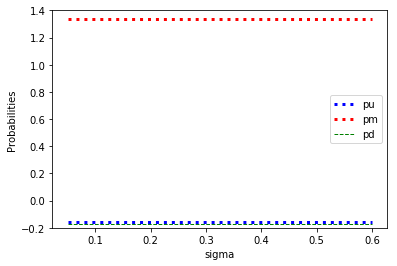

In [8]:
s0 = 100
k = 100
t = 1
r = 0.06
div = 0.03
type = 'call'
dt = t / N
Pu = []
Pm = []
Pd = []

sig = np.arange(0.05, 0.605, 0.05)
for i in sig:
    sigma = 1
    nu = r - div - 0.5 * pow(sigma, 2)
    dx = sigma * np.sqrt(3 * dt)
    edx = np.exp(dx)
    PU = -0.5 * dt * (pow(sigma / dx, 2) + nu / dx)
    PM = 1 + dt * pow(sigma / dx, 2) + r * dt
    PD = -0.5 * dt * (pow(sigma / dx, 2) - nu / dx)
    
    Pu.append(PU)
    Pm.append(PM)
    Pd.append(PD)
    
plt.plot(sig, Pu, 'b:', linewidth = 3, label = 'pu')
plt.plot(sig, Pm, 'r:', linewidth = 3, label = 'pm')
plt.plot(sig, Pd, 'g--', linewidth = 1, label = 'pd')
plt.xlabel('sigma')
plt.ylabel('Probabilities')
plt.ylim(-0.2, 1.4, 0.1)
plt.legend(loc = 'center right')
plt.show()

From the graph we can see that the IFD probabilities almost stay the same with the changes of sigma, and the value of pu and pd is very close.

### Question (f)

In [8]:
sigma = 0.25
t = 1

def Estimate(sigma, t, N):
    error = 0.001
    for i in range(1, N + 1):
        dt = t / i
        dx = sigma * np.sqrt(3 * dt)
        convergence_order = pow(dx, 2) + dt
        if convergence_order < error:
            return i
        
N = Estimate(sigma, t, 1500)
dt = t / N
dx = sigma * np.sqrt(3 * dt)
df =pd.DataFrame([N, dt, dx])
df.index = ['N', 'dt', 'dx']
df

,0
N,1188.000000
dt,0.000842
dx,0.012563


### Question (g)

In [13]:
s0 = 100
k = 100
t = 1
r = 0.06
sigma = 0.25
div = 0.03
def BS_div(s0, k, t, r, sigma, div, type):
    import scipy.stats as stats
    d1 = (np.log(s0 / k) + (r + pow(sigma, 2) / 2 - div) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    
    if type == 'call':
        C = s0 * stats.norm.cdf(d1) * np.exp(-div * t) - k * np.exp(-r * t) * stats.norm.cdf(d2)
        return C
    elif type == 'put':
        P = k * np.exp(-r * t) * stats.norm.cdf(-d2) - s0 * stats.norm.cdf(-d1) * np.exp(-div * t)
        return P

def Empirical_Est(N, type, flag):
    error = 0.001
    BS = BS_div(s0, k, t, r, sigma, div, type)
    for i in range(N - 500, N):
        n = i
        N = i
        if flag == 0:
            D = ExplicitFD_Eur(s0, k, t, r, sigma, N, n, div, type)
        elif flag == 1:
            D = ImplicitFD_Eur(s0, k ,t, r, sigma, N, n, div, type)
        else:
            D = Crank_Nicolson_FD_Eur(s0, k, t, r, sigma, N, n, div, type)
            
        Error = D - BS
        
        if abs(Error) < error:
            return i

In [47]:
N_EFD_C = Empirical_Est(2480, 'call', 0)
dt_EFD_C = t / N_EFD_C
dx_EFD_C = sigma * np.sqrt(3 * dt_EFD_C)

N_EFD_P = Empirical_Est(2650, 'put', 0)
dt_EFD_P = t / N_EFD_P
dx_EFD_P = sigma * np.sqrt(3 * dt_EFD_P)

N_IFD_C = Empirical_Est(5370, 'call', 1)
dt_IFD_C = t / N_IFD_C
dx_IFD_C = sigma * np.sqrt(3 * dt_IFD_C)

N_IFD_P = Empirical_Est(5290, 'put', 1)
dt_IFD_P = t / N_IFD_P
dx_IFD_P = sigma * np.sqrt(3 * dt_IFD_P)

N_CNFD_C = Empirical_Est(3920, 'call', 2)
dt_CNFD_C = t / N_CNFD_C
dx_CNFD_C = sigma * np.sqrt(3 * dt_CNFD_C)

N_CNFD_P = Empirical_Est(3940, 'put', 2)
dt_CNFD_P = t / N_CNFD_P
dx_CNFD_P = sigma * np.sqrt(3 * dt_CNFD_P)

EFD_C = pd.DataFrame([N_EFD_C, dt_EFD_C, dx_EFD_C])
EFD_P = pd.DataFrame([N_EFD_P, dt_EFD_P, dx_EFD_P])
IFD_C = pd.DataFrame([N_IFD_C, dt_IFD_C, dx_IFD_C])
IFD_P = pd.DataFrame([N_IFD_P, dt_IFD_P, dx_IFD_P])
CNFD_C = pd.DataFrame([N_CNFD_C, dt_CNFD_C, dx_CNFD_C])
CNFD_P = pd.DataFrame([N_CNFD_P, dt_CNFD_P, dx_CNFD_P])

df = pd.concat([EFD_C, EFD_P, IFD_C, IFD_P, CNFD_C, CNFD_P], axis = 1)
df.index = ['N', 'dt', 'dx']
df.columns = ['EFD_Call', 'EFD_Put', 'IFD_Call', 'IFD_Put', 'CNFD_Call', 'CNFD_Put']
df

,EFD_Call,EFD_Put,IFD_Call,IFD_Put,CNFD_Call,CNFD_Put
N,1983.000000,2152.000000,4874.000000,4791.000000,3428.000000,3472.000000
dt,0.000504,0.000465,0.000205,0.000209,0.000292,0.000288
dx,0.009724,0.009334,0.006202,0.006256,0.007396,0.007349


### Question (h)

In [16]:
def EFD(s0, k, t, r, sigma, N, Nj, div, type, flag):
    dt = t / N
    nu = r - div - 0.5 * pow(sigma, 2)
    dx = sigma * np.sqrt(3 * dt)
    edx = np.exp(dx)
    pu = 0.5 * dt * (pow(sigma / dx, 2) + nu / dx)
    pm = 1 - dt * pow(sigma / dx, 2) - r * dt
    pd = 0.5 * dt * (pow(sigma / dx, 2) - nu / dx)
    
    St = np.zeros(2 * Nj + 1)
    C = np.zeros([N + 1, 2 * Nj + 1])
    St[-Nj] = s0 * np.exp(-Nj * dx)
    
    for j in range(-Nj + 1, Nj + 1):
        St[j] = St[j - 1] * edx
    
    for j in range(-Nj + 1, Nj + 1):
        if type == 'call':
            C[N, j] = max(0.0, St[j] - k)
        else:
            C[N, j] = max(0.0, k - St[j])
            
    for i in range(N - 1, -1, -1):
        for j in range(-Nj + 1, Nj):
            C[i, j] = pu * C[i + 1, j + 1] + pm * C[i + 1, j] + pd * C[i + 1, j - 1]
            if type == 'call':
                C[i, -Nj] = C[i, -Nj + 1]
                C[i, Nj] = C[i, Nj - 1] + (St[Nj] - St[Nj - 1])
            else:
                C[i, -Nj] = C[i, -Nj + 1] + (St[-Nj + 1] - St[-Nj])
                C[i, Nj] = C[i, Nj - 1]
                
    if flag == 'option':
        return C
    else:
        return St

In [17]:
N = 1188
s0 = 100
k = 100
t = 1
r = 0.06
sigma = 0.25
div = 0.03
C = EFD(s0, k ,t, r, sigma, N, N, div, 'call', 'option')
S = EFD(s0, k ,t, r, sigma, N, N, div, 'call', 'stock')
Delta = (C[0, 2 * N] - C[0, 2 * N - 2]) / (S[2 * N] - S[2 * N - 2])

a = (C[0, 2 * N] - C[0, 2 * N - 1]) / (S[2 * N] - S[2 * N - 1])
b = (C[0, 2 * N - 1] - C[0, 2 * N - 2]) / (S[2 * N - 1] - S[2 * N - 2])
c = 0.5 * (S[2 * N] - S[2 * N - 2])
Gamma = (a - b) / c

dt = t / N
Theta = (C[1, 2 * N] - C[0, 2 * N]) / dt

dsig = 0.001 * 0.25
C1_sig = ExplicitFD_Eur(s0, k, t, r, sigma + dsig, N, N, div, 'call')
C2_sig = ExplicitFD_Eur(s0, k, t, r, sigma - dsig, N, N, div, 'call')
Vega = (C1_sig - C2_sig) / (2 * dsig)

df = pd.DataFrame([Delta, Gamma, Theta, Vega])
df.index = ['Delta', 'Gamma', 'Theta', 'Vega']
df.columns = ['Sensitivities']
df

,Sensitivities
Delta,0.541023
Gamma,0.015714
Theta,-5.733027
Vega,37.563439


## Problem 2

### Question (a)

In [13]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as pdr
import numpy as np
import scipy.stats as sta
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [14]:
# I am using the data form HW2, I have downloaded option price of AMZN and saved it as a cvs file.
# I separated Call amd Put opiton data as two csv files and called 'AMZN_Call_Option'
# and 'AMZN_Put_Option'. Also, I have already selected three different maturities at
# Sep.28.2018, Oct.19.2018, and Nov.16.2018
dfc = pd.read_csv('AMZN_Call_Option.csv')
dfp = pd.read_csv('AMZN_Put_Option.csv')

Select 10 strike prices for 3 different maturities.

In [15]:
AMZN_M1_C = dfc[100:110]
AMZN_M1_P = dfp[100:110]
AMZN_M2_C = dfc[400:410]
AMZN_M2_P = dfp[400:410]
AMZN_M3_C = dfc[550:560]
AMZN_M3_P = dfp[550:560]

Use TM table to save time to maturities

In [16]:
# I have download the data at Sep.24 2018, therefore, I just using this date to calculate TM.
TM1 = (datetime.datetime(2018,9,28) - datetime.datetime(2018,9,24)).days / 365
TM2 = (datetime.datetime(2018,10,19) - datetime.datetime(2018,9,24)).days / 365
TM3 = (datetime.datetime(2018,11,16) - datetime.datetime(2018,9,24)).days / 365
TM = [TM1, TM2, TM3]

Black-Scholes Model

In [17]:
def BSM(s0, k, t, r, sigma, type):
    d1 = (np.log(s0 / k) + (r + pow(sigma, 2) / 2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    
    if type == 'call':
        C = s0 * sta.norm.cdf(d1) - k * np.exp(-r * t) * sta.norm.cdf(d2)
        return C
    elif type == 'put':
        P = k * np.exp(-r * t) * sta.norm.cdf(-d2) - s0 * sta.norm.cdf(-d1)
        return P

Bisection Method

In [18]:
def Bisection_Method(a, b, f):
    if f(a) * f(b) > 0:
        return "no root found"
    else:
        while ((b - a) / 2.0) > 1e-06:
            midpt = (a + b) / 2.0
            if f(midpt) == 0:
                return midpt
            elif f(a) * f(midpt) < 0:
                b = midpt
            else:
                a = midpt
    return midpt

In [19]:
def f(sigma):
    Option_price = BSM(s0, k, t, r, sigma, type)
    return (Option_price-Market_price)

In [20]:
def Implied_Vol(Market_Price, strike):
    Implied_Vol = []
    
    global Market_price
    global k
    
    for i in range(10):
        Market_price = Market_Price[i]
        k = strike[i]
        
        sigma = Bisection_Method(-2, 2, f)
        
        Implied_Vol.append(sigma)
        
    df_Implied_Vol = pd.DataFrame(Implied_Vol)
    return df_Implied_Vol

In [21]:
s0 = 1934.36
r = 0.0192

# Call
type = 'call'
# Maturity 1
t = TM[0]
Market_Price = list((AMZN_M1_C['Bid'] + AMZN_M1_C['Ask'])/2)
strike = list(AMZN_M1_C['Strike'])
Implied_Vol_M1_C = Implied_Vol(Market_Price, strike)

In [22]:
# Maturity 2
t = TM[1]
Market_Price = list((AMZN_M2_C['Bid'] + AMZN_M2_C['Ask'])/2)
strike = list(AMZN_M2_C['Strike'])
Implied_Vol_M2_C = Implied_Vol(Market_Price, strike)

In [23]:
# Maturity 3
t = TM[2]
Market_Price = list((AMZN_M3_C['Bid'] + AMZN_M3_C['Ask'])/2)
strike = list(AMZN_M3_C['Strike'])
Implied_Vol_M3_C = Implied_Vol(Market_Price, strike)

In [24]:
# Put
type = 'put'
# Maturity 1
t = TM[0]
Market_Price = list((AMZN_M1_P['Bid'] + AMZN_M1_P['Ask'])/2)
strike = list(AMZN_M1_P['Strike'])
Implied_Vol_M1_P = Implied_Vol(Market_Price, strike)

In [25]:
# Maturity 2
t = TM[1]
Market_Price = list((AMZN_M2_P['Bid'] + AMZN_M2_P['Ask'])/2)
strike = list(AMZN_M2_P['Strike'])
Implied_Vol_M2_P = Implied_Vol(Market_Price, strike)

In [26]:
# Maturity 3
t = TM[2]
Market_Price = list((AMZN_M3_P['Bid'] + AMZN_M3_P['Ask'])/2)
strike = list(AMZN_M3_P['Strike'])
Implied_Vol_M3_P = Implied_Vol(Market_Price, strike)

In [27]:
Implied_Vol_AMZN = pd.concat([Implied_Vol_M1_C, Implied_Vol_M2_C, Implied_Vol_M3_C,
                        Implied_Vol_M1_P, Implied_Vol_M2_P, Implied_Vol_M3_P], axis = 1)
Implied_Vol_AMZN.columns = ['Implied_Vol_M1_C', 'Implied_Vol_M2_C', 'Implied_Vol_M3_C',
                      'Implied_Vol_M1_P', 'Implied_Vol_M2_P', 'Implied_Vol_M3_P']
Implied_Vol_AMZN

,Implied_Vol_M1_C,Implied_Vol_M2_C,Implied_Vol_M3_C,Implied_Vol_M1_P,Implied_Vol_M2_P,Implied_Vol_M3_P
0,0.118696,0.236078,0.285215,0.452917,0.320684,0.354502
1,0.143957,0.236814,0.285070,0.449453,0.323080,0.355707
2,0.152140,0.239557,0.285738,0.444326,0.366816,0.355097
3,0.163248,0.239779,0.284491,0.447161,0.326994,0.360914
4,0.162561,0.238836,0.280737,0.437437,0.370966,0.183649
5,0.175299,0.237608,0.283495,0.435499,0.374010,0.340094
6,0.180311,0.236212,0.283834,0.437342,0.346087,-0.000002
7,0.173811,0.234236,0.284128,0.432196,0.382494,0.374800
8,0.182955,0.236723,0.283792,0.424379,0.386255,0.362993
9,0.168550,0.237513,0.283751,0.419722,-0.000002,0.396734


### Question (b)

In [28]:
def Calculate_EFD(Market_Price, strike, N, Sigma):
    FD_Price = []
    global Market_price
    global k
    global sigma
    
    for i in range(10):
        Market_price = Market_Price[i]
        k = strike[i]
        sigma = Sigma[i]
        
        EN = Estimate(sigma, t, N)
        FDPrice = ExplicitFD_Eur(s0, k, t, r, sigma, EN, EN, div, type)
        FD_Price.append(FDPrice)
        
    EFD_Option_Price = pd.DataFrame(FD_Price)
    return EFD_Option_Price

In [29]:
def Calculate_IFD(Market_Price, strike, N, Sigma):
    FD_Price = []
    global Market_price
    global k
    global sigma
    
    for i in range(10):
        Market_price = Market_Price[i]
        k = strike[i]
        sigma = Sigma[i]
        
        EN = Estimate(sigma, t, N)
        FDPrice = ImplicitFD_Eur(s0, k, t, r, sigma, EN, EN, div, type)
        FD_Price.append(FDPrice)
        
    IFD_Option_Price = pd.DataFrame(FD_Price)
    return IFD_Option_Price

In [30]:
def Calculate_CNFD(Market_Price, strike, N, Sigma):
    FD_Price = []
    global Market_price
    global k
    global sigma
    
    for i in range(10):
        Market_price = Market_Price[i]
        k = strike[i]
        sigma = Sigma[i]
        
        EN = Estimate(sigma, t, N)
        FDPrice = Crank_Nicolson_FD_Eur(s0, k, t, r, sigma, EN, EN, div, type)
        FD_Price.append(FDPrice)
        
    CNFD_Option_Price = pd.DataFrame(FD_Price)
    return CNFD_Option_Price

In [31]:
# Call
type = 'call'
div = 0
s0 = 1934.36
r = 0.0192
# Maturity 1
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M1_C'])
t = TM[0]
Market_Price = list((AMZN_M1_C['Bid'] + AMZN_M1_C['Ask']) / 2)
strike = list(AMZN_M1_C['Strike'])
# EFD
N = 1983
EFD_M1_C = Calculate_EFD(Market_Price, strike, N, Sigma)
# IFD
N = 4874
IFD_M1_C = Calculate_IFD(Market_Price, strike, N, Sigma)
# CNFD
N = 3428
CNFD_M1_C = Calculate_CNFD(Market_Price, strike, N, Sigma)

In [32]:
# Maturity 2
t = TM[1]
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M2_C'])
Market_Price = list((AMZN_M2_C['Bid'] + AMZN_M2_C['Ask']) / 2)
strike = list(AMZN_M2_C['Strike'])
# EFD
N = 1983
EFD_M2_C = Calculate_EFD(Market_Price, strike, N, Sigma)
# IFD
N = 4874
IFD_M2_C = Calculate_IFD(Market_Price, strike, N, Sigma)
# CNFD
N = 3428
CNFD_M2_C = Calculate_CNFD(Market_Price, strike, N, Sigma)

In [33]:
# Maturity 3
t = TM[2]
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M3_C'])
Market_Price = list((AMZN_M3_C['Bid'] + AMZN_M3_C['Ask']) / 2)
strike = list(AMZN_M3_C['Strike'])
# EFD
N = 1983
EFD_M3_C = Calculate_EFD(Market_Price, strike, N, Sigma)
# IFD
N = 4874
IFD_M3_C = Calculate_IFD(Market_Price, strike, N, Sigma)
# CNFD
N = 3428
CNFD_M3_C = Calculate_CNFD(Market_Price, strike, N, Sigma)

In [34]:
# Put
type = 'put'
# Maturity 1
t = TM[0]
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M1_P'])
Market_Price = list((AMZN_M1_P['Bid'] + AMZN_M1_P['Ask']) / 2)
strike = list(AMZN_M1_P['Strike'])
# EFD
N = 2152
EFD_M1_P = Calculate_EFD(Market_Price, strike, N, Sigma)
# IFD
N = 4791
IFD_M1_P = Calculate_IFD(Market_Price, strike, N, Sigma)
# CNFD
N = 3472
CNFD_M1_P = Calculate_CNFD(Market_Price, strike, N, Sigma)

In [35]:
# Maturity 2
t = TM[1]
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M2_P'])
Market_Price = list((AMZN_M2_P['Bid'] + AMZN_M2_P['Ask']) / 2)
strike = list(AMZN_M2_P['Strike'])
# EFD
N = 2152
EFD_M2_P = Calculate_EFD(Market_Price, strike, N, Sigma)
# IFD
N = 4791
IFD_M2_P = Calculate_IFD(Market_Price, strike, N, Sigma)
# CNFD
N = 3472
CNFD_M2_P = Calculate_CNFD(Market_Price, strike, N, Sigma)

In [36]:
# Maturity 3
t = TM[2]
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M3_P'])
Market_Price = list((AMZN_M3_P['Bid'] + AMZN_M3_P['Ask']) / 2)
strike = list(AMZN_M3_P['Strike'])
# EFD
N = 2152
EFD_M3_P = Calculate_EFD(Market_Price, strike, N, Sigma)
# IFD
N = 4791
IFD_M3_P = Calculate_IFD(Market_Price, strike, N, Sigma)
# CNFD
N = 3472
CNFD_M3_P = Calculate_CNFD(Market_Price, strike, N, Sigma)

In [173]:
Option_Price_Eur = pd.concat([EFD_M1_C, IFD_M1_C, CNFD_M1_C,
                              EFD_M2_C, IFD_M2_C, CNFD_M2_C,
                              EFD_M3_C, IFD_M3_C, CNFD_M3_C,
                              EFD_M1_P, IFD_M1_P, CNFD_M1_P,
                              EFD_M2_P, IFD_M2_P, CNFD_M2_P,
                              EFD_M3_P, IFD_M3_P, CNFD_M3_P], axis = 1)
Option_Price_Eur.columns = ['M1_C_EFD', 'M1_C_IFD', 'M1_C_CNFD',
                            'M2_C_EFD', 'M2_C_IFD', 'M2_C_CNFD',
                            'M3_C_EFD', 'M3_C_IFD', 'M3_C_CNFD',
                            'M1_P_EFD', 'M1_P_IFD', 'M1_P_CNFD',
                            'M2_P_EFD', 'M2_P_IFD', 'M2_P_CNFD',
                            'M3_P_EFD', 'M3_P_IFD', 'M3_P_CNFD']
Option_Price_Eur

,M1_C_EFD,M1_C_IFD,M1_C_CNFD,M2_C_EFD,M2_C_IFD,M2_C_CNFD,M3_C_EFD,M3_C_IFD,M3_C_CNFD,M1_P_EFD,M1_P_IFD,M1_P_CNFD,M2_P_EFD,M2_P_IFD,M2_P_CNFD,M3_P_EFD,M3_P_IFD,M3_P_CNFD
0,40.232476,40.308880,40.271972,39.341565,39.197521,39.269685,88.553933,88.437317,88.495685,3.679197,3.838169,3.757855,1.377786e+02,137.705569,1.377418e+02,191.974549,191.892530,191.933498
1,38.654499,38.716098,38.684623,37.384746,37.245349,37.315168,87.229507,87.112641,87.171135,3.777459,3.931710,3.853552,1.419213e+02,141.853850,1.418873e+02,195.908660,195.829487,195.869027
2,36.703577,36.743270,36.721339,36.013142,35.876858,35.945095,86.175664,86.058351,86.117069,3.829244,3.979125,3.903007,1.531087e+02,153.020545,1.530644e+02,199.361137,199.285318,199.323177
3,34.969842,34.978542,34.970773,34.147804,34.016414,34.082177,84.656205,84.539637,84.597982,4.102736,4.246571,4.173052,1.503936e+02,150.338404,1.503657e+02,215.612529,215.546522,215.579458
4,32.986349,32.965687,32.972718,32.053301,31.927634,31.990506,82.400595,82.285168,82.342941,4.026015,4.166449,4.094646,1.612462e+02,161.168489,1.612071e+02,195.649764,195.686297,195.668007
5,31.811162,31.729886,31.767175,29.901478,29.781740,29.841619,82.055392,81.939694,81.997602,4.166238,4.301633,4.232093,1.656493e+02,165.576906,1.656128e+02,241.719716,241.689941,241.704728
6,30.189848,30.075217,30.129817,27.995671,27.882459,27.939041,81.000664,80.885055,80.942918,4.499987,4.624642,4.560135,1.652956e+02,165.248843,1.652719e+02,NaN,230.970975,NaN
7,27.839002,27.699203,27.765991,26.081878,25.977832,26.029794,79.932657,79.817156,79.874965,4.651964,4.766598,4.707019,1.749131e+02,174.848794,1.748807e+02,273.577153,273.549797,273.563372
8,26.518066,26.339930,26.426701,24.986640,24.889294,24.937878,78.679473,78.564341,78.621964,4.767321,4.877517,4.820057,1.794686e+02,179.408892,1.794385e+02,304.391995,304.394386,304.393084
9,23.660620,23.471749,23.563408,23.577319,23.486747,23.531912,77.512676,77.397791,77.455290,4.929990,5.029469,4.977237,-1.073705e+141,158.839528,-1.988825e+105,319.535467,319.527409,319.531330


### Question (c)

In [69]:
def Delta(strike, Sigma, N, type, change):
    Delta = []
    global k, sigma
    
    for i in range(10):
        k = strike[i]
        sigma = Sigma[i]
        EN = Estimate(sigma, t, N)
        delta = (ExplicitFD_Eur(s0 + change, k, t, r, sigma, EN, EN, div, type) - ExplicitFD_Eur(s0, k, t, r, sigma, EN, EN, div, type)) / change
        Delta.append(delta)
        
    EFD_Delta = pd.DataFrame(Delta)
    return EFD_Delta

In [73]:
def Gamma(strike, Sigma, N, type, change):
    Gamma = []
    global k, sigma
    
    for i in range(10):
        k = strike[i]
        sigma = Sigma[i]
        EN = Estimate(sigma, t, N)
        gamma = (ExplicitFD_Eur(s0 + change, k, t, r, sigma, EN, EN, div, type) - 2 * ExplicitFD_Eur(s0, k, t, r, sigma, EN, EN, div, type) + 
                 ExplicitFD_Eur(s0 - change, k, t, r, sigma, EN, EN, div, type)) / 2 * change
        Gamma.append(gamma)
        
    EFD_Gamma = pd.DataFrame(Gamma)
    return EFD_Gamma

In [74]:
def Vega(strike, Sigma, N, type, change):
    Vega = []
    global k, sigma
    
    for i in range(10):
        k = strike[i]
        sigma = Sigma[i]
        EN = Estimate(sigma, t, N)
        vega = (ExplicitFD_Eur(s0, k, t, r, sigma + change, EN, EN, div, type) - ExplicitFD_Eur(s0, k, t, r, sigma, EN, EN, div, type)) / change
        Vega.append(vega)
        
    EFD_Vega = pd.DataFrame(Vega)
    return EFD_Vega

In [82]:
def Theta(strike, Sigma, N, type):
    Theta = []
    global k, sigma
    
    for i in range(10):
        k = strike[i]
        k2 = strike[i - 1]
        sigma = Sigma[i]
        sigma2 = Sigma[i - 1]
        EN = Estimate(sigma, t, N)
        EN2 = Estimate(sigma2, t, N)
        dt = t / EN
        theta = (ExplicitFD_Eur(s0, k, t, r, sigma, EN, EN, div, type) - ExplicitFD_Eur(s0, k2, t, r, sigma2, EN2, EN2, div, type)) / dt
        Theta.append(theta)
    EFD_Theta = pd.DataFrame(Theta)
    return EFD_Theta

In [84]:
# Call
type = 'call'
change = 0.0001
div = 0
s0 = 1934.36
r = 0.0192
N = 1983
# Maturity 1
strike = list(AMZN_M1_C['Strike'])
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M1_C'])
Delta_M1_C = Delta(strike, Sigma, N, type, change)
Gamma_M1_C = Gamma(strike, Sigma, N, type, change)
Vega_M1_C = Vega(strike, Sigma, N, type, change)
Theta_M1_C = Theta(strike, Sigma, N, type)

In [85]:
# Maturity 2
strike = list(AMZN_M2_C['Strike'])
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M2_C'])
Delta_M2_C = Delta(strike, Sigma, N, type, change)
Gamma_M2_C = Gamma(strike, Sigma, N, type, change)
Vega_M2_C = Vega(strike, Sigma, N, type, change)
Theta_M2_C = Theta(strike, Sigma, N, type)

In [86]:
# Maturity 3
strike = list(AMZN_M3_C['Strike'])
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M3_C'])
Delta_M3_C = Delta(strike, Sigma, N, type, change)
Gamma_M3_C = Gamma(strike, Sigma, N, type, change)
Vega_M3_C = Vega(strike, Sigma, N, type, change)
Theta_M3_C = Theta(strike, Sigma, N, type)

In [87]:
# Put
type = 'put'
change = 0.0001
div = 0
s0 = 1934.36
r = 0.0192
N = 2152
# Maturity 1
strike = list(AMZN_M1_P['Strike'])
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M1_P'])
Delta_M1_P = Delta(strike, Sigma, N, type, change)
Gamma_M1_P = Gamma(strike, Sigma, N, type, change)
Vega_M1_P = Vega(strike, Sigma, N, type, change)
Theta_M1_P = Theta(strike, Sigma, N, type)

In [88]:
# Maturity 2
strike = list(AMZN_M2_P['Strike'])
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M2_P'])
Delta_M2_P = Delta(strike, Sigma, N, type, change)
Gamma_M2_P = Gamma(strike, Sigma, N, type, change)
Vega_M2_P = Vega(strike, Sigma, N, type, change)
Theta_M2_P = Theta(strike, Sigma, N, type)

In [89]:
# Maturity 3
strike = list(AMZN_M3_P['Strike'])
Sigma = list(Implied_Vol_AMZN['Implied_Vol_M3_P'])
Delta_M3_P = Delta(strike, Sigma, N, type, change)
Gamma_M3_P = Gamma(strike, Sigma, N, type, change)
Vega_M3_P = Vega(strike, Sigma, N, type, change)
Theta_M3_P = Theta(strike, Sigma, N, type)

In [91]:
Cor = pd.concat([Delta_M1_C, Gamma_M1_C, Vega_M1_C, Theta_M1_C, 
                 Delta_M2_C, Gamma_M2_C, Vega_M2_C, Theta_M2_C,
                 Delta_M3_C, Gamma_M3_C, Vega_M3_C, Theta_M3_C,
                 Delta_M1_P, Gamma_M1_P, Vega_M1_P, Theta_M1_P, 
                 Delta_M2_P, Gamma_M2_P, Vega_M2_P, Theta_M2_P,
                 Delta_M3_P, Gamma_M3_P, Vega_M3_P, Theta_M3_P], axis = 1)

Cor.columns = ['Delta_M1_C', 'Gamma_M1_C', 'Vega_M1_C', 'Theta_M1_C', 
                 'Delta_M2_C', 'Gamma_M2_C', 'Vega_M2_C', 'Theta_M2_C',
                 'Delta_M3_C', 'Gamma_M3_C', 'Vega_M3_C', 'Theta_M3_C',
                 'Delta_M1_P', 'Gamma_M1_P', 'Vega_M1_P', 'Theta_M1_P', 
                 'Delta_M2_P', 'Gamma_M2_P', 'Vega_M2_P', 'Theta_M2_P',
                 'Delta_M3_P', 'Gamma_M3_P', 'Vega_M3_P', 'Theta_M3_P']
Cor

,Delta_M1_C,Gamma_M1_C,Vega_M1_C,Theta_M1_C,Delta_M2_C,Gamma_M2_C,Vega_M2_C,Theta_M2_C,Delta_M3_C,Gamma_M3_C,...,Vega_M1_P,Theta_M1_P,Delta_M2_P,Gamma_M2_P,Vega_M2_P,Theta_M2_P,Delta_M3_P,Gamma_M3_P,Vega_M3_P,Theta_M3_P
0,0.658681,1.023182e-16,712.239667,-25109.269543,0.569086,-2.586376e-16,763.157794,21802.955251,0.592699,2.287948e-16,...,708.628912,19873.540860,-0.479000,-9.663381e-17,772.987226,NaN,-0.491444,-2.387424e-16,770.648510,-179257.605298
1,0.632395,-1.492140e-16,728.800167,17856.780871,0.549149,-1.307399e-16,762.805974,-2013.958224,0.592688,-3.907985e-16,...,709.367592,-1927.820875,-0.478572,-2.273737e-17,774.066272,6338.322812,-0.491216,6.252776e-17,771.746713,5551.274529
2,0.631069,2.302158e-16,731.936597,4887.099352,0.549376,4.604317e-16,764.289096,-157.789322,0.573597,-2.557954e-17,...,710.174538,-3802.668555,-0.470518,-3.637979e-16,771.419867,51624.011456,-0.491331,2.103206e-16,773.010091,3615.661365
3,0.609619,1.278977e-16,739.143073,7318.733811,0.549390,-5.826450e-17,765.896925,-2413.435825,0.573460,-3.012701e-16,...,710.630537,5230.166594,-0.496901,-1.023182e-16,769.238438,-36560.562306,-0.508684,-2.842171e-18,768.939818,23644.427046
4,0.609678,1.506351e-16,740.237500,-1994.609156,0.549316,-1.108447e-16,767.582147,-3457.070326,0.573055,-8.242296e-17,...,711.640319,-8930.902202,-0.469720,-5.115908e-17,773.453830,52166.376864,-0.637397,2.017941e-16,722.217804,-134381.420881
5,0.608647,8.810730e-17,742.833289,8867.866108,0.549211,-4.121148e-17,769.298016,-3712.016547,0.573354,-1.364242e-16,...,716.401368,-196.124359,-0.487433,-2.557954e-17,767.853026,7705.375844,-0.531984,-1.648459e-16,769.970224,177235.440372
6,0.608371,1.705303e-17,744.338570,2641.468353,0.528977,2.700062e-17,767.088211,-3774.895111,0.573389,8.526513e-17,...,716.897183,4106.675252,-0.493150,-2.557954e-17,771.357963,-25030.628342,NaN,NaN,NaN,NaN
7,0.608749,1.094236e-16,744.899774,-6723.654442,0.528792,2.131628e-17,768.875979,-4255.927780,0.573423,4.263256e-18,...,717.740365,-3746.612107,-0.485650,7.958079e-17,769.501184,44837.477456,-0.523896,-2.415845e-16,774.128549,NaN
8,0.608247,2.060574e-16,746.627011,6054.509401,0.529030,1.449507e-16,770.305134,-258.186588,0.573384,7.531753e-17,...,718.704877,-6666.468961,-0.484840,3.780087e-16,770.353825,8711.080495,-0.563426,-1.023182e-16,759.369396,24919.494004
9,0.588814,1.634248e-16,748.782889,-13115.426588,0.529102,9.947598e-17,771.859059,-1782.811504,0.573380,2.131628e-17,...,719.513269,-3161.267547,NaN,NaN,NaN,NaN,-0.536539,7.105427e-17,772.315212,48025.924754


### Question (d)

In [198]:
K_C = pd.concat([AMZN_M1_C, AMZN_M2_C, AMZN_M3_C])['Strike']
K_C = pd.DataFrame(K_C)
K_C.columns = ['Strike Price']
K_C = K_C.reset_index(drop = True)

K_P = pd.concat([AMZN_M1_P, AMZN_M2_P, AMZN_M3_P])['Strike']
K_P = pd.DataFrame(K_P)
K_P.columns = ['Strike Price']
K_P = K_P.reset_index(drop = True)

frames = [K_C, K_P]
K = pd.concat(frames, keys = ['Call', 'Put'], axis = 1)

In [199]:
A_C = pd.concat([AMZN_M1_C, AMZN_M2_C, AMZN_M3_C])['Ask']
A_C = pd.DataFrame(A_C)
A_C.columns = ['Ask Price']
A_C = A_C.reset_index(drop = True)

A_P = pd.concat([AMZN_M1_P, AMZN_M2_P, AMZN_M3_P])['Ask']
A_P = pd.DataFrame(A_P)
A_P.columns = ['Ask Price']
A_P = A_P.reset_index(drop = True)

frames = [A_C, A_P]
A = pd.concat(frames, keys = ['Call', 'Put'], axis = 1)

In [200]:
B_C = pd.concat([AMZN_M1_C, AMZN_M2_C, AMZN_M3_C])['Bid']
B_C = pd.DataFrame(B_C)
B_C.columns = ['Bid Price']
B_C = B_C.reset_index(drop = True)

B_P = pd.concat([AMZN_M1_P, AMZN_M2_P, AMZN_M3_P])['Bid']
B_P = pd.DataFrame(B_P)
B_P.columns = ['Bid Price']
B_P = B_P.reset_index(drop = True)

frames = [B_C, B_P]
B = pd.concat(frames, keys = ['Call', 'Put'], axis = 1)

In [201]:
C_A = pd.concat([AMZN_M1_C, AMZN_M2_C, AMZN_M3_C])['Ask']
C_B = pd.concat([AMZN_M1_C, AMZN_M2_C, AMZN_M3_C])['Bid']
CM_C = (C_B + C_A) / 2
CM_C = pd.DataFrame(CM_C)
CM_C.columns = ['Market Price']
CM_C = CM_C.reset_index(drop = True)

P_A = pd.concat([AMZN_M1_P, AMZN_M2_P, AMZN_M3_P])['Ask']
P_B = pd.concat([AMZN_M1_P, AMZN_M2_P, AMZN_M3_P])['Bid']
CM_P = (P_B + P_A) / 2
CM_P = pd.DataFrame(CM_P)
CM_P.columns = ['Market Price']
CM_P = CM_P.reset_index(drop = True)

frames = [CM_C, CM_P]
CM = pd.concat(frames, keys = ['Call', 'Put'], axis = 1)

In [231]:
EFD_C = pd.concat([EFD_M1_C, EFD_M2_C, EFD_M3_C])
EFD_C.columns = ['EFD Option Price']

EFD_P = pd.concat([EFD_M1_P, EFD_M2_P, EFD_M3_P])
EFD_P.columns = ['EFD Option Price']

frames = [EFD_C, EFD_P]
EFD = pd.concat(frames, keys = ['Call', 'Put'], axis = 1)
EFD = EFD.reset_index(drop = True)

In [232]:
IFD_C = pd.concat([IFD_M1_C, IFD_M2_C, IFD_M3_C])
IFD_C.columns = ['IFD Option Price']

IFD_P = pd.concat([IFD_M1_P, IFD_M2_P, IFD_M3_P])
IFD_P.columns = ['IFD Option Price']

frames = [IFD_C, IFD_P]
IFD = pd.concat(frames, keys = ['Call', 'Put'], axis = 1)
IFD = IFD.reset_index(drop = True)

In [233]:
CNFD_C = pd.concat([CNFD_M1_C, CNFD_M2_C, CNFD_M3_C])
CNFD_C.columns = ['CNFD Option Price']

CNFD_P = pd.concat([CNFD_M1_P, CNFD_M2_P, CNFD_M3_P])
CNFD_P.columns = ['CNFD Option Price']

frames = [CNFD_C, CNFD_P]
CNFD = pd.concat(frames, keys = ['Call', 'Put'], axis = 1)
CNFD = CNFD.reset_index(drop = True)

In [228]:
Implied_Vol_C = pd.concat([Implied_Vol_M1_C, Implied_Vol_M2_C, Implied_Vol_M3_C])
Implied_Vol_C.columns = ['Implied Volatility']

Implied_Vol_P = pd.concat([Implied_Vol_M1_P, Implied_Vol_M2_P, Implied_Vol_M3_P])
Implied_Vol_P.columns = ['Implied Volatility']

frames = [Implied_Vol_C, Implied_Vol_P]
Implied_Vol = pd.concat(frames, keys = ['Call', 'Put'], axis = 1)
Implied_Vol = Implied_Vol.reset_index(drop = True)

In [234]:
Final_table = pd.concat([K, A, B, CM, Implied_Vol, EFD, IFD, CNFD], axis = 1)
Final_table

,Call,Put,Call,Put,Call,Put,Call,Put,Call,Put,Call,Put,Call,Put,Call,Put
,Strike Price,Strike Price,Ask Price,Ask Price,Bid Price,Bid Price,Market Price,Market Price,Implied Volatility,Implied Volatility,EFD Option Price,EFD Option Price,IFD Option Price,IFD Option Price,CNFD Option Price,CNFD Option Price
0,1895.0,1815.0,40.85,3.75,39.60,3.55,40.225,3.650,0.118696,0.452917,40.232476,3.679197e+00,40.308880,3.838169,40.271972,3.757855e+00
1,1897.5,1817.5,39.10,3.90,38.10,3.65,38.600,3.775,0.143957,0.449453,38.654499,3.777459e+00,38.716098,3.931710,38.684623,3.853552e+00
2,1900.0,1820.0,37.30,4.00,36.10,3.70,36.700,3.850,0.152140,0.444326,36.703577,3.829244e+00,36.743270,3.979125,36.721339,3.903007e+00
3,1902.5,1822.5,35.40,4.35,34.75,4.05,35.075,4.200,0.163248,0.447161,34.969842,4.102736e+00,34.978542,4.246571,34.970773,4.173052e+00
4,1905.0,1825.0,33.00,4.25,32.95,4.00,32.975,4.125,0.162561,0.437437,32.986349,4.026015e+00,32.965687,4.166449,32.972718,4.094646e+00
5,1907.5,1827.5,32.10,4.45,31.30,4.20,31.700,4.325,0.175299,0.435499,31.811162,4.166238e+00,31.729886,4.301633,31.767175,4.232093e+00
6,1910.0,1830.0,30.60,4.85,29.60,4.50,30.100,4.675,0.180311,0.437342,30.189848,4.499987e+00,30.075217,4.624642,30.129817,4.560135e+00
7,1912.5,1832.5,28.30,4.90,27.35,4.65,27.825,4.775,0.173811,0.432196,27.839002,4.651964e+00,27.699203,4.766598,27.765991,4.707019e+00
8,1915.0,1835.0,27.15,4.90,26.15,4.65,26.650,4.775,0.182955,0.424379,26.518066,4.767321e+00,26.339930,4.877517,26.426701,4.820057e+00


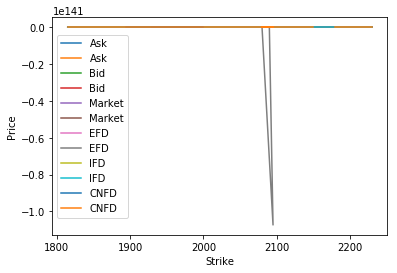

In [259]:
plt.plot(K, A, label = 'Ask')
plt.plot(K, B, label = 'Bid')
plt.plot(K, CM, label = 'Market')
plt.plot(K, EFD, label = 'EFD')
plt.plot(K, IFD, label = 'IFD')
plt.plot(K, CNFD, label = 'CNFD')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend(loc = 'center left')
plt.show()

## Problem 3

### Question 3

In [263]:
import pandas as PD
import numpy as np

In [281]:
def EFD(s0, k, t, N, Nj, div, type):
    x = s0
    sigma = np.sqrt(4 * abs(np.sin(x)))
    r = 0.2 * np.sqrt(pow(x, 3)) + 2 * np.sin(x)
    dt = t / N
    nu = r - div - 0.5 * pow(sigma, 2)
    dx = sigma * np.sqrt(3 * dt)
    edx = np.exp(dx)
    pu = dt * ((np.sin(x) / dx) + (np.sqrt(pow(x, 3)) / 5 * pow(dx, 2)))
    pm = 1 - dt * (2 * np.sqrt(pow(x, 3)) / 5 * pow(dx, 2)) - r * dt
    pd = dt * ((-np.sin(x) / dx) + (np.sqrt(pow(x, 3)) / 5 * pow(dx, 2)))
    
    St = np.zeros(2 * Nj + 1)
    C = np.zeros([N + 1, 2 * Nj + 1])
    St[-Nj] = s0 * np.exp(-Nj * dx)
    
    for j in range(-Nj + 1, Nj + 1):
        St[j] = St[j - 1] * edx
    
    for j in range(-Nj + 1, Nj + 1):
        if type == 'call':
            C[N, j] = max(0.0, St[j] - k)
        else:
            C[N, j] = max(0.0, k - St[j])
            
    for i in range(N - 1, -1, -1):
        for j in range(-Nj + 1, Nj):
            C[i, j] = pu * C[i + 1, j + 1] + pm * C[i + 1, j] + pd * C[i + 1, j - 1]
            if type == 'call':
                C[i, -Nj] = C[i, -Nj + 1]
                C[i, Nj] = C[i, Nj - 1] + (St[Nj] - St[Nj - 1])
            else:
                C[i, -Nj] = C[i, -Nj + 1] + (St[-Nj + 1] - St[-Nj])
                C[i, Nj] = C[i, Nj - 1]
    return C[0, 0]

In [283]:
s0 = 100
k = 100
t = 1
N = 500
div = 0
Option_Price = EFD(s0, k, t, N, N, div, 'put')
Option_Price

5.172366788359688e-109